Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers,callbacks
import matplotlib.pyplot as plt
import numpy as np
import os

Define veriables 

In [2]:
img_size=256
batch_size=32

Produce dataset from the potato images folder

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\projects\potato_disease_classification\mine\dataset\potato",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


Display the classes (folders) in dataset

In [4]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Show the length of the dataset (No. of batches)

In [5]:
len(dataset)

68

So, here we have 68 batches, each has 32 images.

To show tensors of the first batch

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.numpy())

[[[[161. 156. 163.]
   [156. 151. 158.]
   [155. 150. 157.]
   ...
   [186. 184. 189.]
   [188. 186. 191.]
   [197. 195. 200.]]

  [[176. 171. 178.]
   [177. 172. 179.]
   [183. 178. 185.]
   ...
   [189. 187. 192.]
   [190. 188. 193.]
   [179. 177. 182.]]

  [[156. 151. 158.]
   [154. 149. 156.]
   [156. 151. 158.]
   ...
   [206. 204. 209.]
   [202. 200. 205.]
   [187. 185. 190.]]

  ...

  [[ 97.  97. 109.]
   [100. 100. 112.]
   [104. 104. 116.]
   ...
   [151. 154. 169.]
   [138. 141. 156.]
   [141. 144. 159.]]

  [[105. 104. 118.]
   [108. 107. 121.]
   [122. 121. 135.]
   ...
   [177. 180. 195.]
   [163. 166. 181.]
   [171. 174. 189.]]

  [[117. 116. 130.]
   [116. 115. 129.]
   [131. 130. 144.]
   ...
   [135. 138. 153.]
   [130. 133. 148.]
   [153. 156. 171.]]]


 [[[184. 183. 191.]
   [181. 180. 188.]
   [178. 177. 185.]
   ...
   [163. 166. 185.]
   [168. 170. 191.]
   [170. 172. 193.]]

  [[181. 180. 188.]
   [179. 178. 186.]
   [178. 177. 185.]
   ...
   [166. 169. 186.]
 

To show images size of the first batch

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


To show all images in the first batch

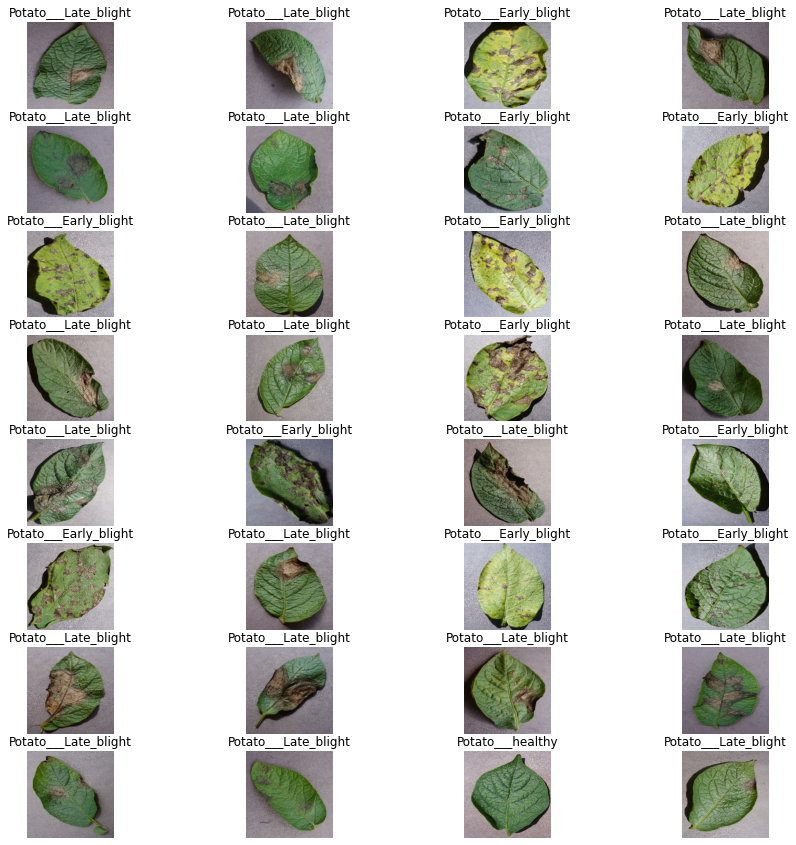

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(batch_size):
        ax=plt.subplot(int(batch_size/4),4,i+1)
#        convert from float to int
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis('off')

Split dataset to train, validation, and test datsets. In this project, train dataset is 80% of dataset, validation is 10% and test is 10%.

In [9]:
#  Split function 
def split_tr_val_ts(ds,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True, shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

#     dataset size
    ds_size=len(ds)
#     train size
    train_size= int(ds_size*train_size)
#     validation size
    val_size= int(ds_size*val_size)
    
#     train dataset:
    train_ds=dataset.take(train_size)
#     validation dataset:
    val_ds=ds.skip(train_size).take(val_size)
#     Test dataset:
    test_ds=ds.skip(train_size).skip(val_size)
        
#     print results
    print(
        f'Dataset size: {ds_size} batches\nTrain dataset size: {len(train_ds)} batches\nValidation dataset size: {len(val_ds)} batches\nTest dataset size: {len(test_ds)} batches\n'
    )
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds=split_tr_val_ts(dataset)

Dataset size: 68 batches
Train dataset size: 54 batches
Validation dataset size: 6 batches
Test dataset size: 8 batches



To optimize the performance, will use Cashe and prefetch

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Pre proccessing

Resize images, in case the new images sizes are not same as in dataset.
Rescale images, to rescale images to (0-255)

In [12]:
resize_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Augmentation images, to let the model more robust

In [13]:
img_augmentation= tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.5),
    layers.RandomContrast(0.5),
])

Run augmentation on training dataset

In [14]:
train_ds = train_ds.map(
    lambda x, y: (img_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Build the model

In [15]:
input_shape=(img_size,img_size,3)
padding = 'same'
kernel_size = 3
model=models.Sequential([
    layers.Input(input_shape),
    resize_rescale,
    layers.Rescaling((1./255)),
    layers.Conv2D(16, kernel_size, padding=padding, activation='relu', strides=1, 
    data_format='channels_last'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(32, kernel_size, padding=padding, activation='relu'), # best 4
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(64, kernel_size, padding=padding, activation='relu'), # best 3
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(128, kernel_size, padding=padding, activation='relu'), # best 3
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'), # best 1
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'), # best 1
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'), # best 1
    layers.Dropout(0.1),
    layers.Dense(3, activation = 'softmax')
 ])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)       

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Early Stopping

In [18]:
es=callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [19]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
#     ,callbacks=[es]
)

Epoch 1/50
54/54 [==============================] - 224s 4s/step - loss: 0.8988 - accuracy: 0.7523 - val_loss: 2.9186 - val_accuracy: 0.4226
Epoch 2/50
54/54 [==============================] - 179s 3s/step - loss: 0.5871 - accuracy: 0.8275 - val_loss: 1.4108 - val_accuracy: 0.4226
Epoch 3/50
54/54 [==============================] - 186s 3s/step - loss: 0.5434 - accuracy: 0.8275 - val_loss: 1.1313 - val_accuracy: 0.4226
Epoch 4/50
54/54 [==============================] - 183s 3s/step - loss: 0.3608 - accuracy: 0.8819 - val_loss: 1.8770 - val_accuracy: 0.4226
Epoch 5/50
54/54 [==============================] - 183s 3s/step - loss: 0.2906 - accuracy: 0.9039 - val_loss: 1.4789 - val_accuracy: 0.4226
Epoch 6/50
54/54 [==============================] - 178s 3s/step - loss: 0.2594 - accuracy: 0.9074 - val_loss: 1.4635 - val_accuracy: 0.4940
Epoch 7/50
54/54 [==============================] - 180s 3s/step - loss: 0.2437 - accuracy: 0.9213 - val_loss: 1.4429 - val_accuracy: 0.4226
Epoch 8/50
54

Evaluate the model

In [20]:
score = model.evaluate(test_ds)

8/8 [==============================] - 6s 437ms/step - loss: 4.4102 - accuracy: 0.5312


Plotting the history of the training model

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Plot Training and Validation Loss

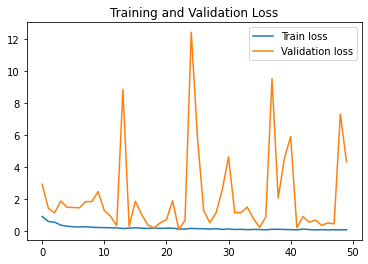

In [24]:
plt.plot( loss,label='Train loss')
plt.plot( val_loss,label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Plot Training and Validation Accuracy

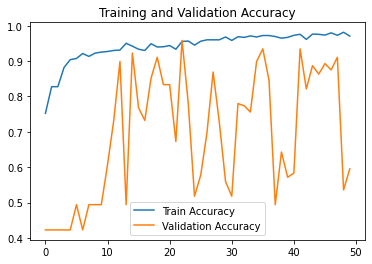

In [25]:
plt.plot(acc,label='Train Accuracy')
plt.plot( val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Prediction using test dataset

In [26]:
# prediction function
def pred_img(img):
#     Convert the image to array
    img_array= tf.keras.preprocessing.image.img_to_array(img.numpy())
#     Create a batch
    img_array=tf.expand_dims(img_array,0)
    
#     predict the image
    pred=model.predict(img_array)
    
#     Select the class of the predicted image
    pred_class=dataset.class_names[np.argmax(pred[0])]
#     Accuracy of the prediction
    confidence=round((np.max(pred[0])*100),2)
    
    return pred_class, confidence

C:\Users\husam\AppData\Local\Temp/ipykernel_12900/3275457925.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax=plt.subplot(col,4,i+1)


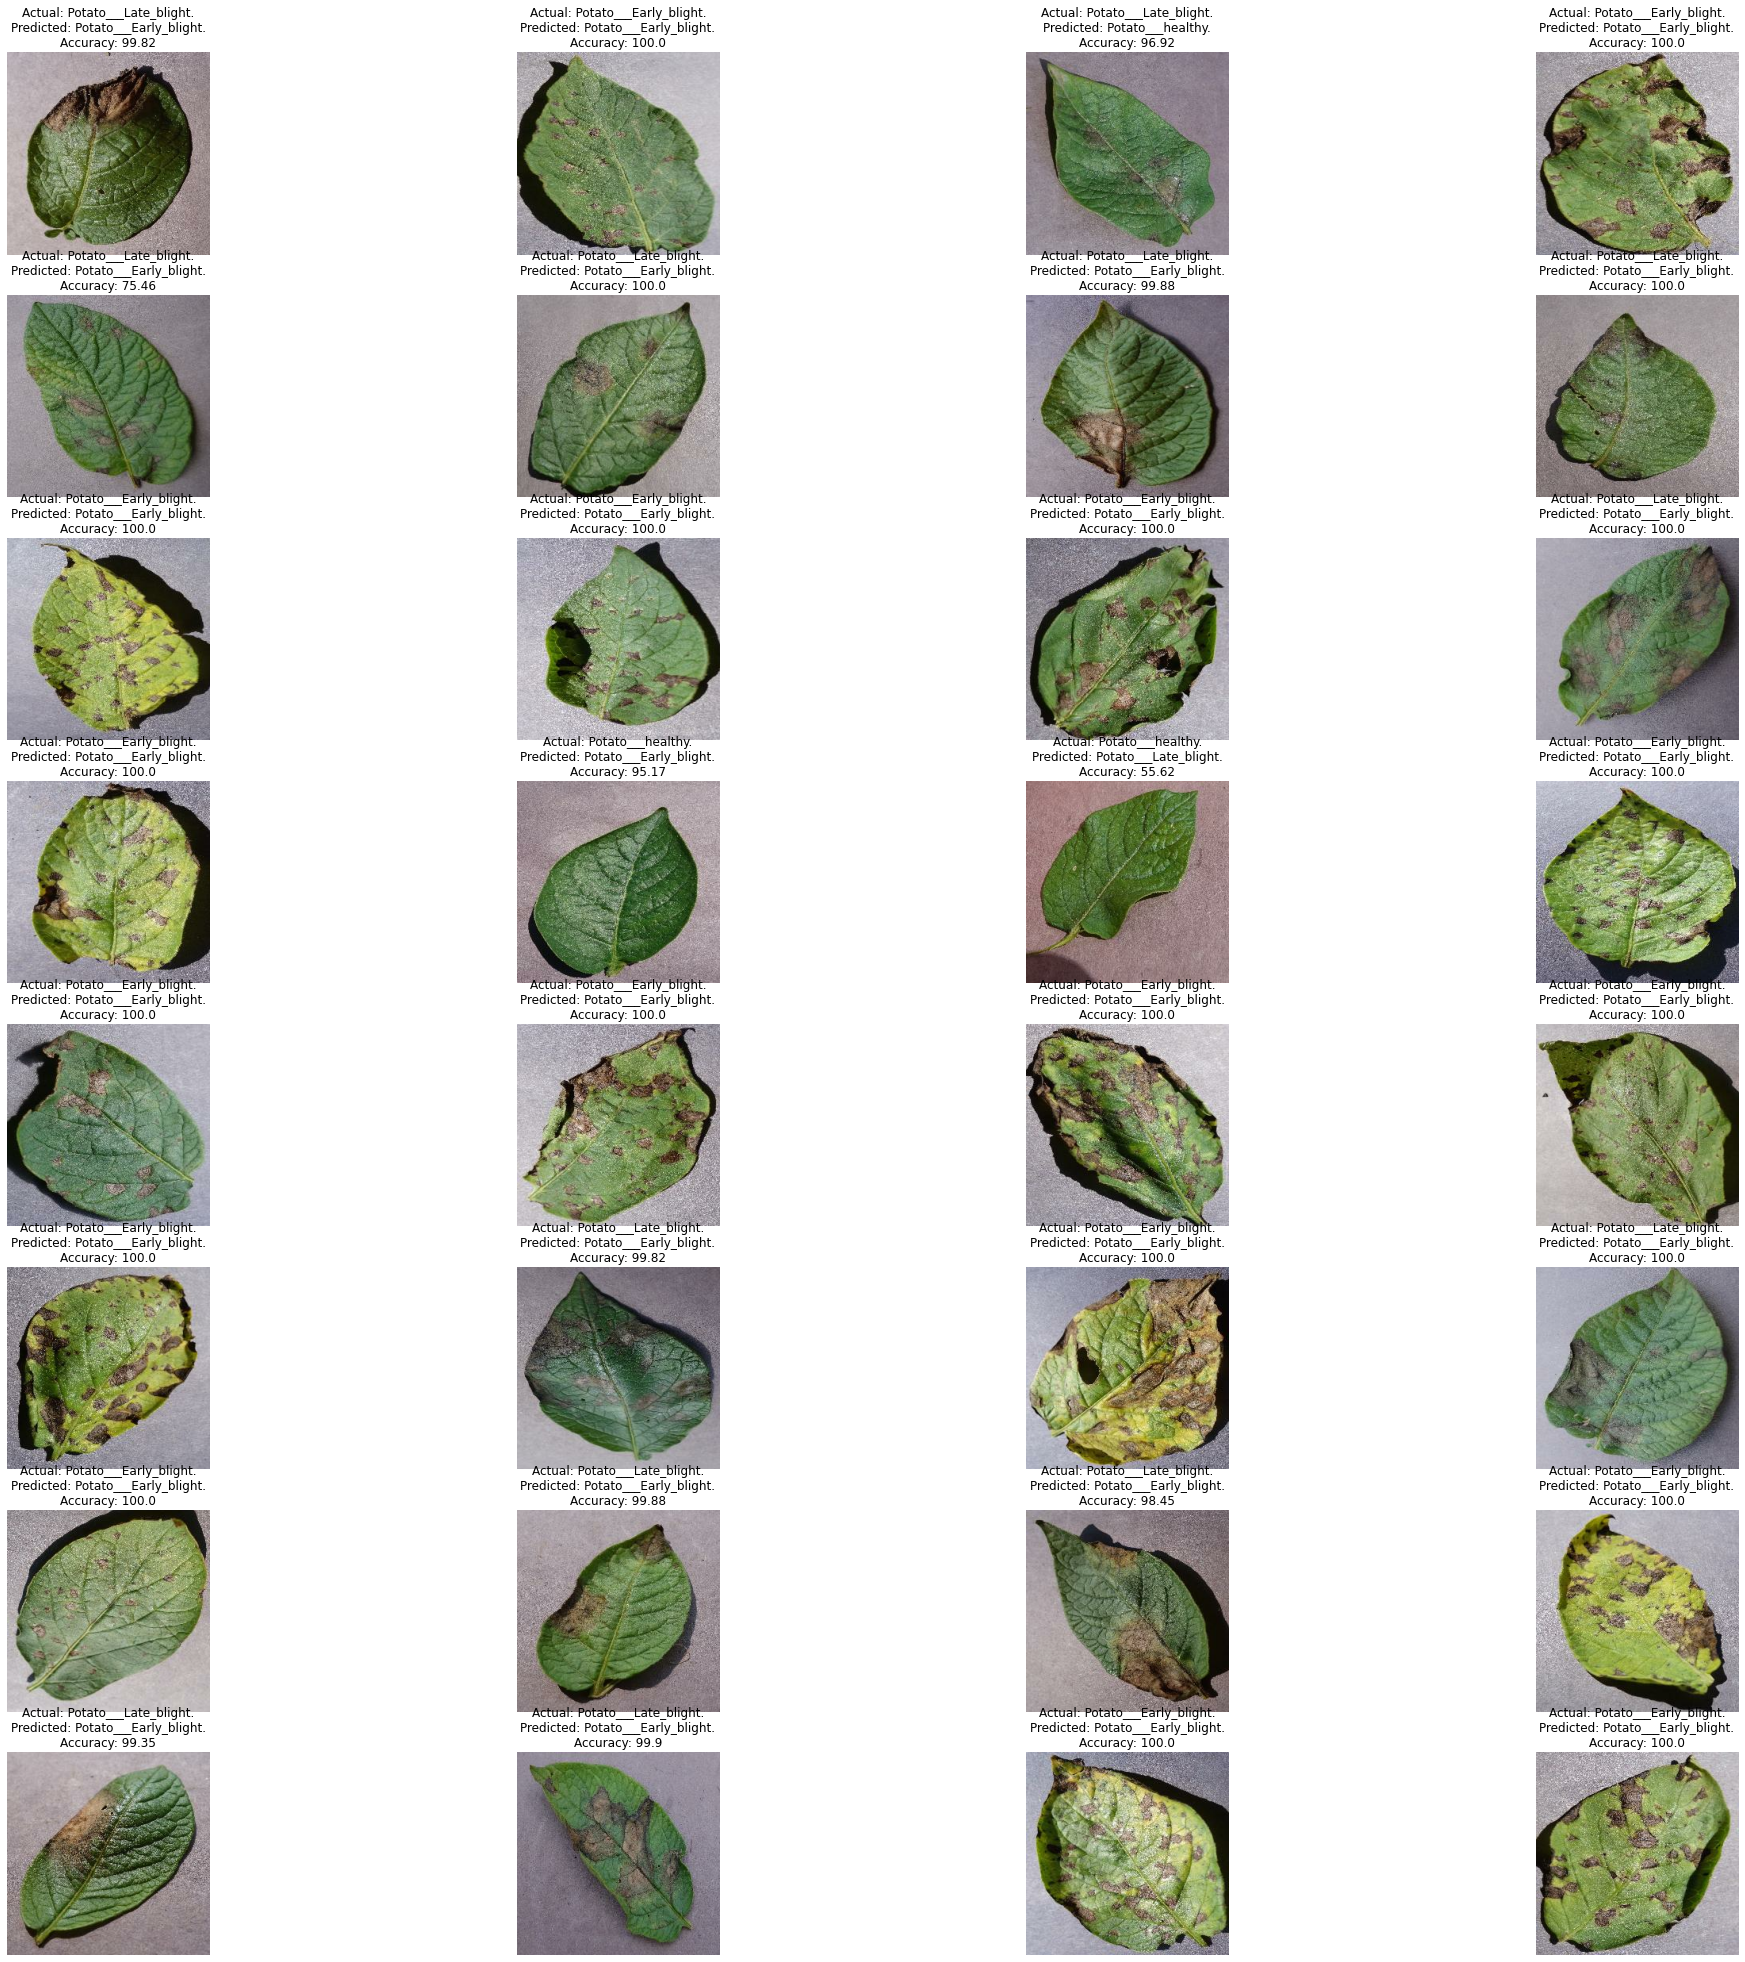

In [30]:
# Show the prediction results of the first batch in test dataset 
plt.figure(figsize=(35,35))
for image,label in test_ds.take(1):
    for i in range (batch_size):
#         predict the image and get the predicted class and the accuracy
        pred_class, confidence = pred_img(image[i])
#         the actual class of the image
        actual_class= dataset.class_names[label[i]]
#     plot the image with its info
        col=batch_size/4
        ax=plt.subplot(col,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(
            f'Actual: {actual_class}.\nPredicted: {pred_class}.\nAccuracy: {confidence}'
        )
        plt.axis('off')

Save model

In [28]:
model.save('.\models\PDC_norm_dropout')
model.save(".\models\PDC_norm_dropout.h5")

INFO:tensorflow:Assets written to: .\models\PDC_norm_dropout\assets


Load model

In [29]:
model_loaded = tf.keras.models.load_model('./models/PDC_norm_dropout')